In [117]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as T
import torchvision
import torch 
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook as tqdm 
import os
import time
from datetime import datetime 
from knn_monitor import knn_monitor
from model import ContrastiveLearner
from logger import Logger
import torch.nn as nn
import kornia.augmentation.functional as F
from torchvision.transforms import functional as tvF

from PIL import ImageFilter
from PIL import Image

%matplotlib inline
import kornia

In [118]:
uid = 'SimCLR'
dataset_name = 'cifar10'
data_dir = 'dataset'
ckpt_dir = "./ckpt"
features = 128
batch_size = 4
epochs = 15
lr = 1e-3
use_cuda = False
device_id = 0
wt_decay  = 0.9
image_size = (32,32)
device = "cpu"
s = 0.2

CIFAR_MEAN =  torch.FloatTensor([0.49139968, 0.48215827, 0.44653124])
CIFAR_STD  =  torch.FloatTensor([0.24703233, 0.24348505, 0.26158768])

In [126]:

import matplotlib.pyplot as plt

def plot_images(im1, im2):
    plt.subplot(121)
    plt.title("Original Image")
    plt.imshow(im1)
    plt.subplot(122)
    plt.title("Augmentation Image")
    plt.imshow(im2)
    plt.show()



def tensor_pre_transform_wrapper(input: torch.Tensor):
    """ A wrapper that tried to reproduce the actual output from:
        - transforms.ToPILImage()
        - transforms.ToTensor()
        For each image, simply (img * 255).int() // 255
    """
    return torch.round(input * 255).to(torch.uint8) / 255.


class InitalTransformation():
    def __init__(self, image_size=None, s=1.0):
        self.transform = T.Compose([
            T.ToTensor(),
        ])

    def __call__(self, x):
        x = self.transform(x)
        return  x



train_loader = torch.utils.data.DataLoader(
        dataset = torchvision.datasets.CIFAR10(data_dir, train=True,        transform=InitalTransformation(), download=False),
        shuffle=True,
        batch_size= batch_size,
        num_workers = 2
)


train_transform = nn.Sequential(
            kornia.augmentation.RandomResizedCrop(image_size,scale=(0.2,1.0)),
            kornia.augmentation.RandomHorizontalFlip(p=1.0),
            kornia.augmentation.ColorJitter(0.8*s,0.8*s,0.8*s,0.2*s,p=1.0),
            kornia.augmentation.RandomGrayscale(p=0.2),
            # kornia.augmentation.Normalize(CIFAR_MEAN,CIFAR_STD),

        )



<ipython-input-127-aa9083103880>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  local_progress = tqdm(train_loader, desc=f'Epoch {1}/{1}')


Epoch 1/1:   0%|          | 0/12500 [00:00<?, ?it/s]

torch.Size([3, 32, 32])


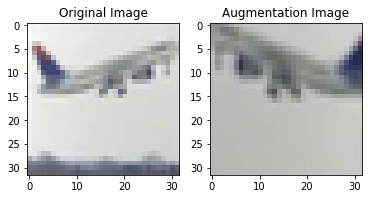

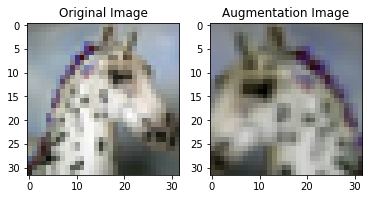

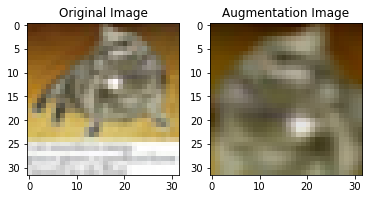

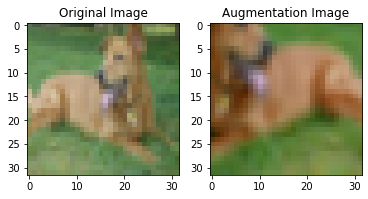

In [127]:



train_loader = torch.utils.data.DataLoader(
        dataset = torchvision.datasets.CIFAR10(data_dir, train=True,        transform=InitalTransformation(), download=False),
        shuffle=True,
        batch_size= batch_size,
        num_workers = 2
)

local_progress = tqdm(train_loader, desc=f'Epoch {1}/{1}')
for idx, (images, label) in enumerate(local_progress):
        images = images.to(device)
        aug_image = train_transform(images)
        break

from matplotlib.pyplot import imshow    
print((aug_image[0].shape))

for i in range(0,images.shape[0]):
    im = np.asarray(transforms.ToPILImage()(images[i,:,:,:])).copy()
    aug = np.asarray(transforms.ToPILImage()(aug_image[i,:,:,:]))
    
    plot_images(im,aug)